In [1]:
from astropy.io import fits
from astropy.time import Time
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import mpl_defaults as mpld
import theano.tensor as tt
import copy
%matplotlib inline

In [2]:
# source: https://sohowww.nascom.nasa.gov/data/archive.html
blue = fits.open('blue.fits')
green = fits.open('green.fits')
red = fits.open('red.fits')

r, g, b = red[0].data, green[0].data, blue[0].data
mask = np.isfinite(r) & np.isfinite(g) & np.isfinite(b)
start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, len(r)) - start
r, g, b = r[mask].astype('float64'), g[mask].astype('float64'), b[mask].astype('float64')
r, g, b = copy.deepcopy(r), copy.deepcopy(g), copy.deepcopy(b)
t = t[mask]
flux = np.sum([r, g, b], axis=0)/3

In [3]:
i = 58273
di = 2000
t = t[i:i+di]# * 60

add_wn = np.exp(-4)
wn = np.random.randn(3, len(t))*add_wn

r, g, b = r[i:i+di]/1e3 + wn[0], g[i:i+di]/1e3 + wn[1], b[i:i+di]/1e3 + wn[2]

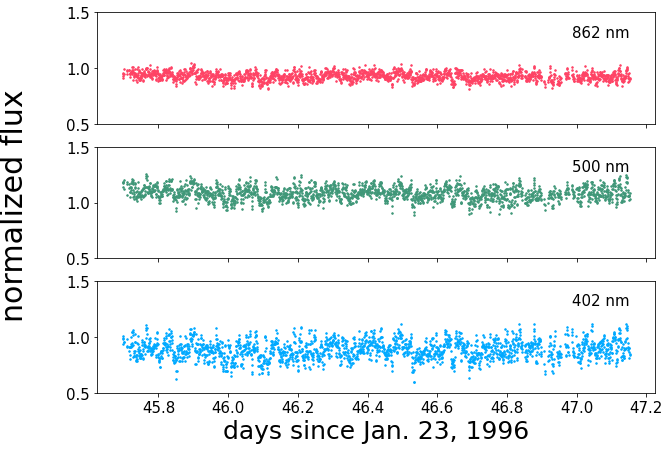

In [4]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+r, '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+g, '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+b, '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/spm_lc.pdf")

In [5]:
import pymc3 as pm
import theano.tensor as tt

def find_map_soln(r, g, b, mcmc=False, n_minimizations=1):
    y = np.vstack((r, g, b)).T.reshape(3*len(t),)
    
    with pm.Model() as model:

        logw0 = pm.Uniform("logw0", lower=-3.0, upper=1.0, testval=-1.0)
        logw1 = pm.Uniform("logw1", lower=5.0, upper=7.0, testval=6.5)
        logw2 = pm.Uniform("logw2", lower=7.0, upper=10.0, testval=7.5)
        
        logQ = pm.Uniform("logQ", lower=0.0, upper=3.0, testval=1.5)
        
        ls0 = pm.Uniform("ls0", lower=-20, upper=0.0, testval=-6)
        ls1 = pm.Uniform("ls1", lower=-20, upper=0.0, testval=-7)
        ls2 = pm.Uniform("ls2", lower=-20, upper=0.0, testval=-8)
        
        ldg0 = pm.Uniform("ldg0", lower=0.0, upper=2.0, testval=0.5)
        ldg1 = pm.Uniform("ldg1", lower=0.0, upper=2.0, testval=0.5)
        ldg2 = pm.Uniform("ldg2", lower=0.0, upper=2.0, testval=0.5)
        
        ldb0 = pm.Uniform("ldb0", lower=0.0, upper=2.0, testval=0.5)
        ldb1 = pm.Uniform("ldb1", lower=0.0, upper=2.0, testval=0.5)
        ldb2 = pm.Uniform("ldb2", lower=0.0, upper=2.0, testval=0.5)
                
        term0 = xo.gp.terms.SHOTerm(
            log_S0 = ls0,
            log_w0 = logw0,
            log_Q = -np.log(np.sqrt(2))
        )
        term1 = xo.gp.terms.SHOTerm(
            log_S0 = ls1,
            log_w0 = logw1,
            log_Q = -np.log(np.sqrt(2))
        )
        term2 = xo.gp.terms.SHOTerm(
            log_S0 = ls2,
            log_w0 = logw2,
            log_Q = logQ
        )
        
        q0 = tt.exp(tt.stack([0.0, ldg0, ldb0]))
        q1 = tt.exp(tt.stack([0.0, ldg1, ldb1]))
        q2 = tt.exp(tt.stack([0.0, ldg2, ldb2]))
        
        mean_r = pm.Normal("mean_r", mu=0, sd=0.5, testval=np.mean(r))
        mean_g = pm.Normal("mean_g", mu=0, sd=0.5, testval=np.mean(g))
        mean_b = pm.Normal("mean_b", mu=0, sd=0.5, testval=np.mean(b))
        logsig_r = pm.Uniform("logsig_r", lower=-15.0, upper=0.0, testval=-5.0)
        logsig_g = pm.Uniform("logsig_g", lower=-15.0, upper=0.0, testval=-5.0)
        logsig_b = pm.Uniform("logsig_b", lower=-15.0, upper=0.0, testval=-5.0)
        
        kernel = (xo.gp.terms.KroneckerTerm(term0, q0) + 
                  xo.gp.terms.KroneckerTerm(term1, q1) + 
                  xo.gp.terms.KroneckerTerm(term2, q2))
        
        yerr = tt.exp(2 * tt.stack([logsig_r, logsig_g, logsig_b]))
        yerr = yerr[:, None] * tt.ones(len(t))
        
        mean = tt.stack([mean_r, mean_g, mean_b])
        mean = mean[:, None] * tt.ones(len(t))
        mean = tt.reshape(mean.T, (3*len(t),))
        
        gp = xo.gp.GP(kernel, t, yerr, J=6)
        pm.Potential("loglike", gp.log_likelihood(y - mean))
        
        start = model.test_point
        map_soln = None
        for i in range(n_minimizations):
            map_soln = xo.optimize(start=start, verbose=True)
            start = map_soln
        if mcmc:
            trace = pm.sample(
                tune=1000,
                draws=1000,
                start=start,
                cores=2,
                chains=2,
                step=xo.get_dense_nuts_step(target_accept=0.9)
            )
            return model, map_soln, trace
        else:
            return model, map_soln, None

In [6]:
model, map_soln, trace = find_map_soln(r, g, b, mcmc=True, n_minimizations=1)

optimizing logp for variables: [logsig_b, logsig_g, logsig_r, mean_b, mean_g, mean_r, ldb2, ldb1, ldb0, ldg2, ldg1, ldg0, ls2, ls1, ls0, logQ, logw2, logw1, logw0]
241it [00:05, 46.92it/s, logp=1.644740e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -12645.254271177171 -> 16447.39534369267
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig_b, logsig_g, logsig_r, mean_b, mean_g, mean_r, ldb2, ldb1, ldb0, ldg2, ldg1, ldg0, ls2, ls1, ls0, logQ, logw2, logw1, logw0]
Sampling 2 chains, 13 divergences: 100%|██████████| 4000/4000 [37:52<00:00,  1.64draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
map_soln

{'logw0_interval__': array(2.79187594),
 'logw1_interval__': array(3.01081644),
 'logw2_interval__': array(-3.73619257),
 'logQ_interval__': array(-4.57639186),
 'ls0_interval__': array(0.78302061),
 'ls1_interval__': array(-0.77017624),
 'ls2_interval__': array(-1.32393499),
 'ldg0_interval__': array(-0.79058991),
 'ldg1_interval__': array(-0.70876792),
 'ldg2_interval__': array(-2.86248523),
 'ldb0_interval__': array(-3.51915295),
 'ldb1_interval__': array(-0.05107836),
 'ldb2_interval__': array(-0.00367151),
 'mean_r': array(-0.06727902),
 'mean_g': array(0.08925806),
 'mean_b': array(-0.10921619),
 'logsig_r_interval__': array(1.04186485),
 'logsig_g_interval__': array(1.01504891),
 'logsig_b_interval__': array(0.99284343),
 'logw0': array(0.76894093),
 'logw1': array(6.90612079),
 'logw2': array(7.06986817),
 'logQ': array(0.03056136),
 'ls0': array(-6.27338484),
 'ls1': array(-13.67118032),
 'ls2': array(-15.79671283),
 'ldg0': array(0.62408404),
 'ldg1': array(0.65974228),
 'ldg

In [8]:
def get_kernel(d):
    
    logw0 = d["logw0"]
    logw1 = d["logw1"]
    logw2 = d["logw2"]
        
    logQ = d["logQ"]
    
    term0 = xo.gp.terms.SHOTerm(
            log_S0 = d["ls0"],
            log_w0 = logw0,
            log_Q = -np.log(np.sqrt(2))
    )
    term1 = xo.gp.terms.SHOTerm(
            log_S0 = d["ls1"],
            log_w0 = logw1,
            log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
            log_S0 = d["ls2"],
            log_w0 = logw2,
            log_Q = logQ
    )

    q0 = tt.exp(tt.stack([0.0, d["ldg0"], d["ldb0"]])) 
    q1 = tt.exp(tt.stack([0.0, d["ldg1"], d["ldb1"]])) 
    q2 = tt.exp(tt.stack([0.0, d["ldg2"], d["ldb2"]])) 
                
    kernel = (xo.gp.terms.KroneckerTerm(term0, q0) + 
              xo.gp.terms.KroneckerTerm(term1, q1) + 
              xo.gp.terms.KroneckerTerm(term2, q2))
                
    return kernel

In [9]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fftr = np.fft.rfft(r)
fftg = np.fft.rfft(g)
fftb = np.fft.rfft(b)

fftr *= np.conj(fftr)
fftg *= np.conj(fftg)
fftb *= np.conj(fftb)

powerfftr = fftr.real / len(t)**2
powerfftg = fftg.real / len(t)**2
powerfftb = fftb.real / len(t)**2

In [10]:
#map_soln["logdw"] = 0.7
#map_soln["logw"] = 6.8
#map_soln["lg2"] = -8
#map_soln["logQ"] = 1.2
#map_soln["ldr2"] = 0.5
#map_soln["ldb2"] = 0.5
#map_soln["lr2"] = map_soln["lg2"] - map_soln["ldr2"]
#map_soln["lb2"] = map_soln["lg2"] + map_soln["ldb2"]

In [11]:
kernel = get_kernel(map_soln)
psd = kernel.psd(2*np.pi*f).T.eval()

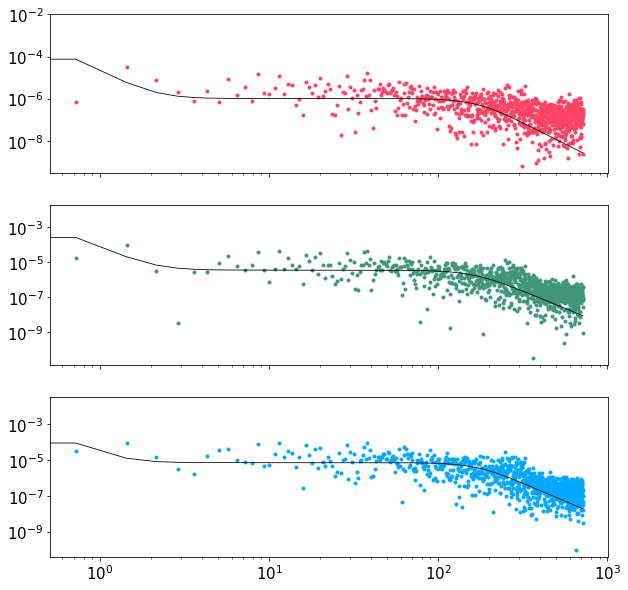

In [12]:
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfftr, '.', color=mpld.red)
ax[1].loglog(f, powerfftg, '.', color=mpld.green)
ax[2].loglog(f, powerfftb, '.', color=mpld.blue)

ax[0].loglog(f, psd[0], color='k', linewidth=0.8)
ax[1].loglog(f, psd[1], color='k', linewidth=0.8)
ax[2].loglog(f, psd[2], color='k', linewidth=0.8)

In [13]:
m = 3
gp = xo.gp.GP(kernel, t, np.exp(-10)*np.ones((m, len(t))) ** 2, J=6)
z = gp.dot_l(np.random.randn(m*len(t), 1)).eval()

Text(0.0, 0.3, 'normalized flux')

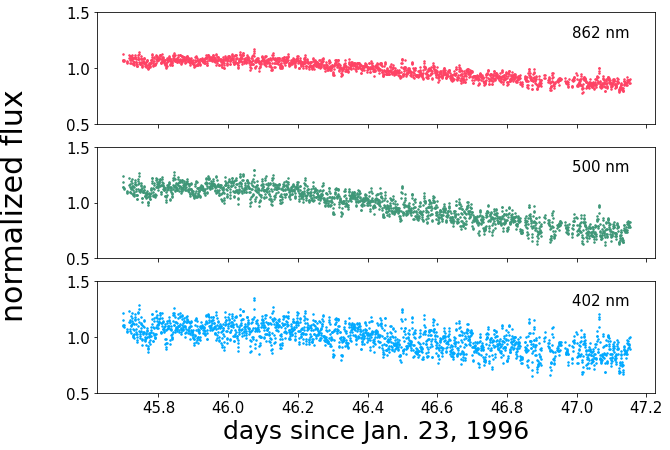

In [14]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+z[::3], '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+z[1::3], '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+z[2::3], '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)

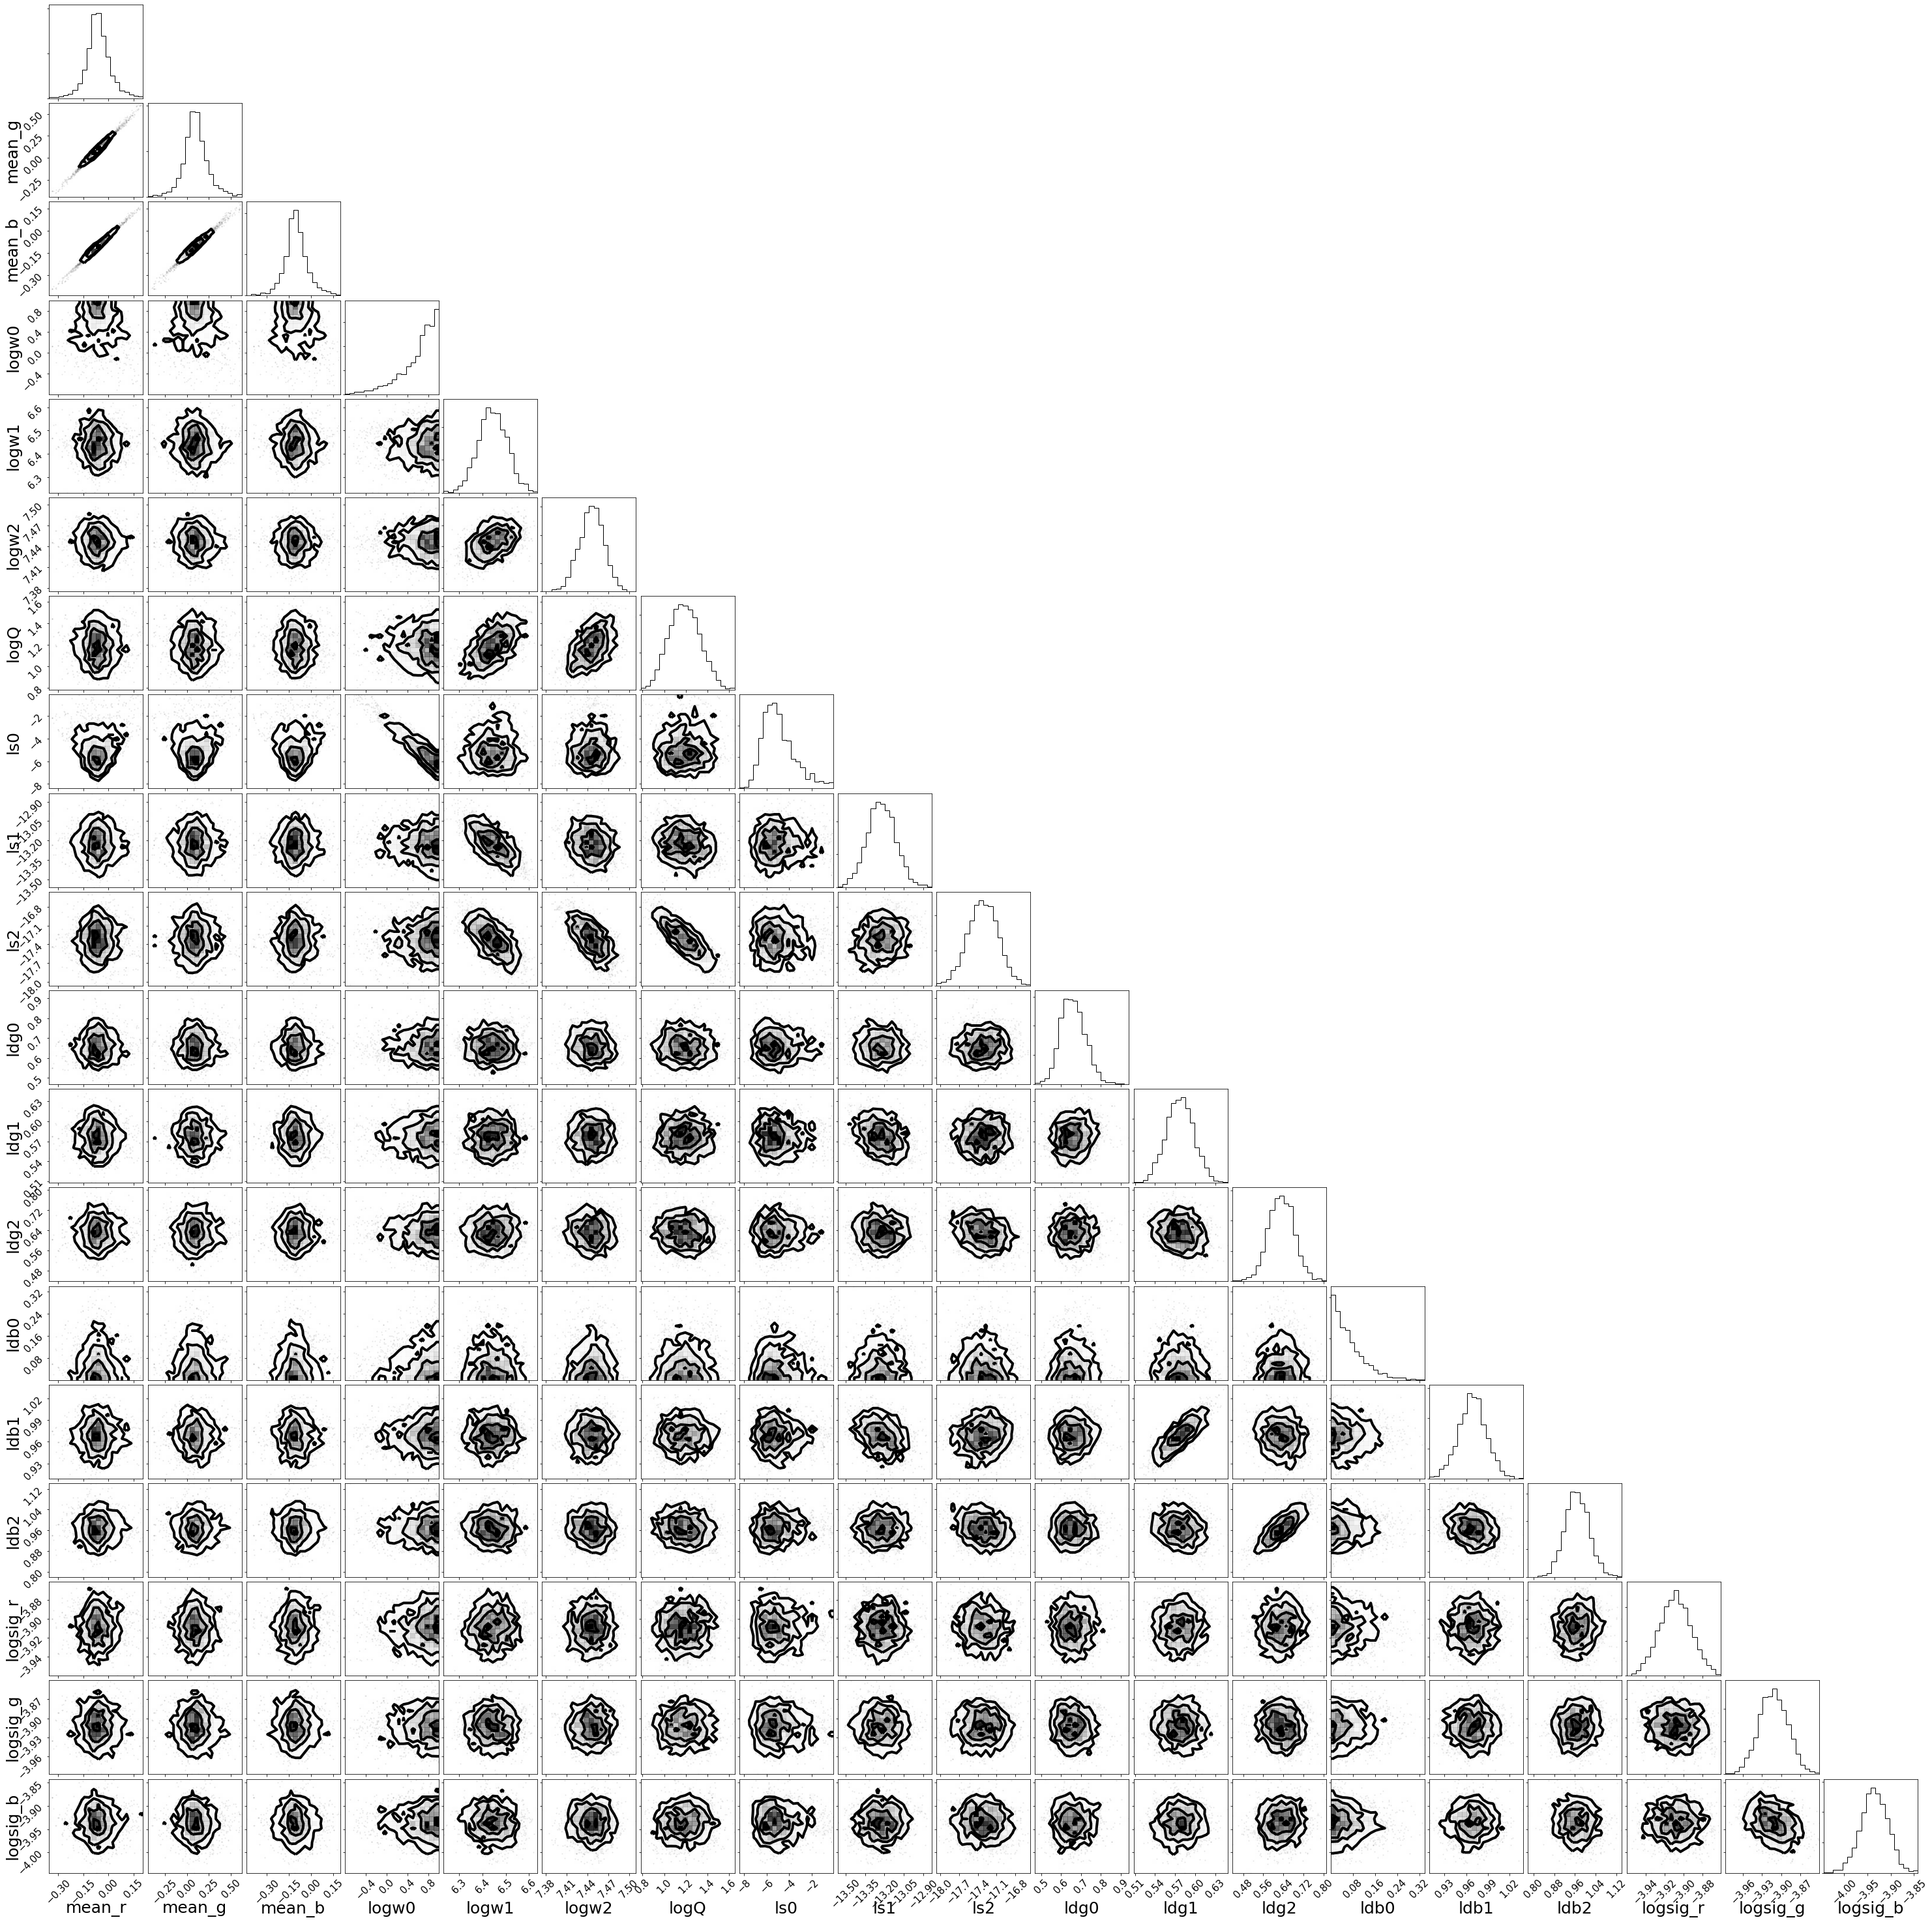

In [15]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

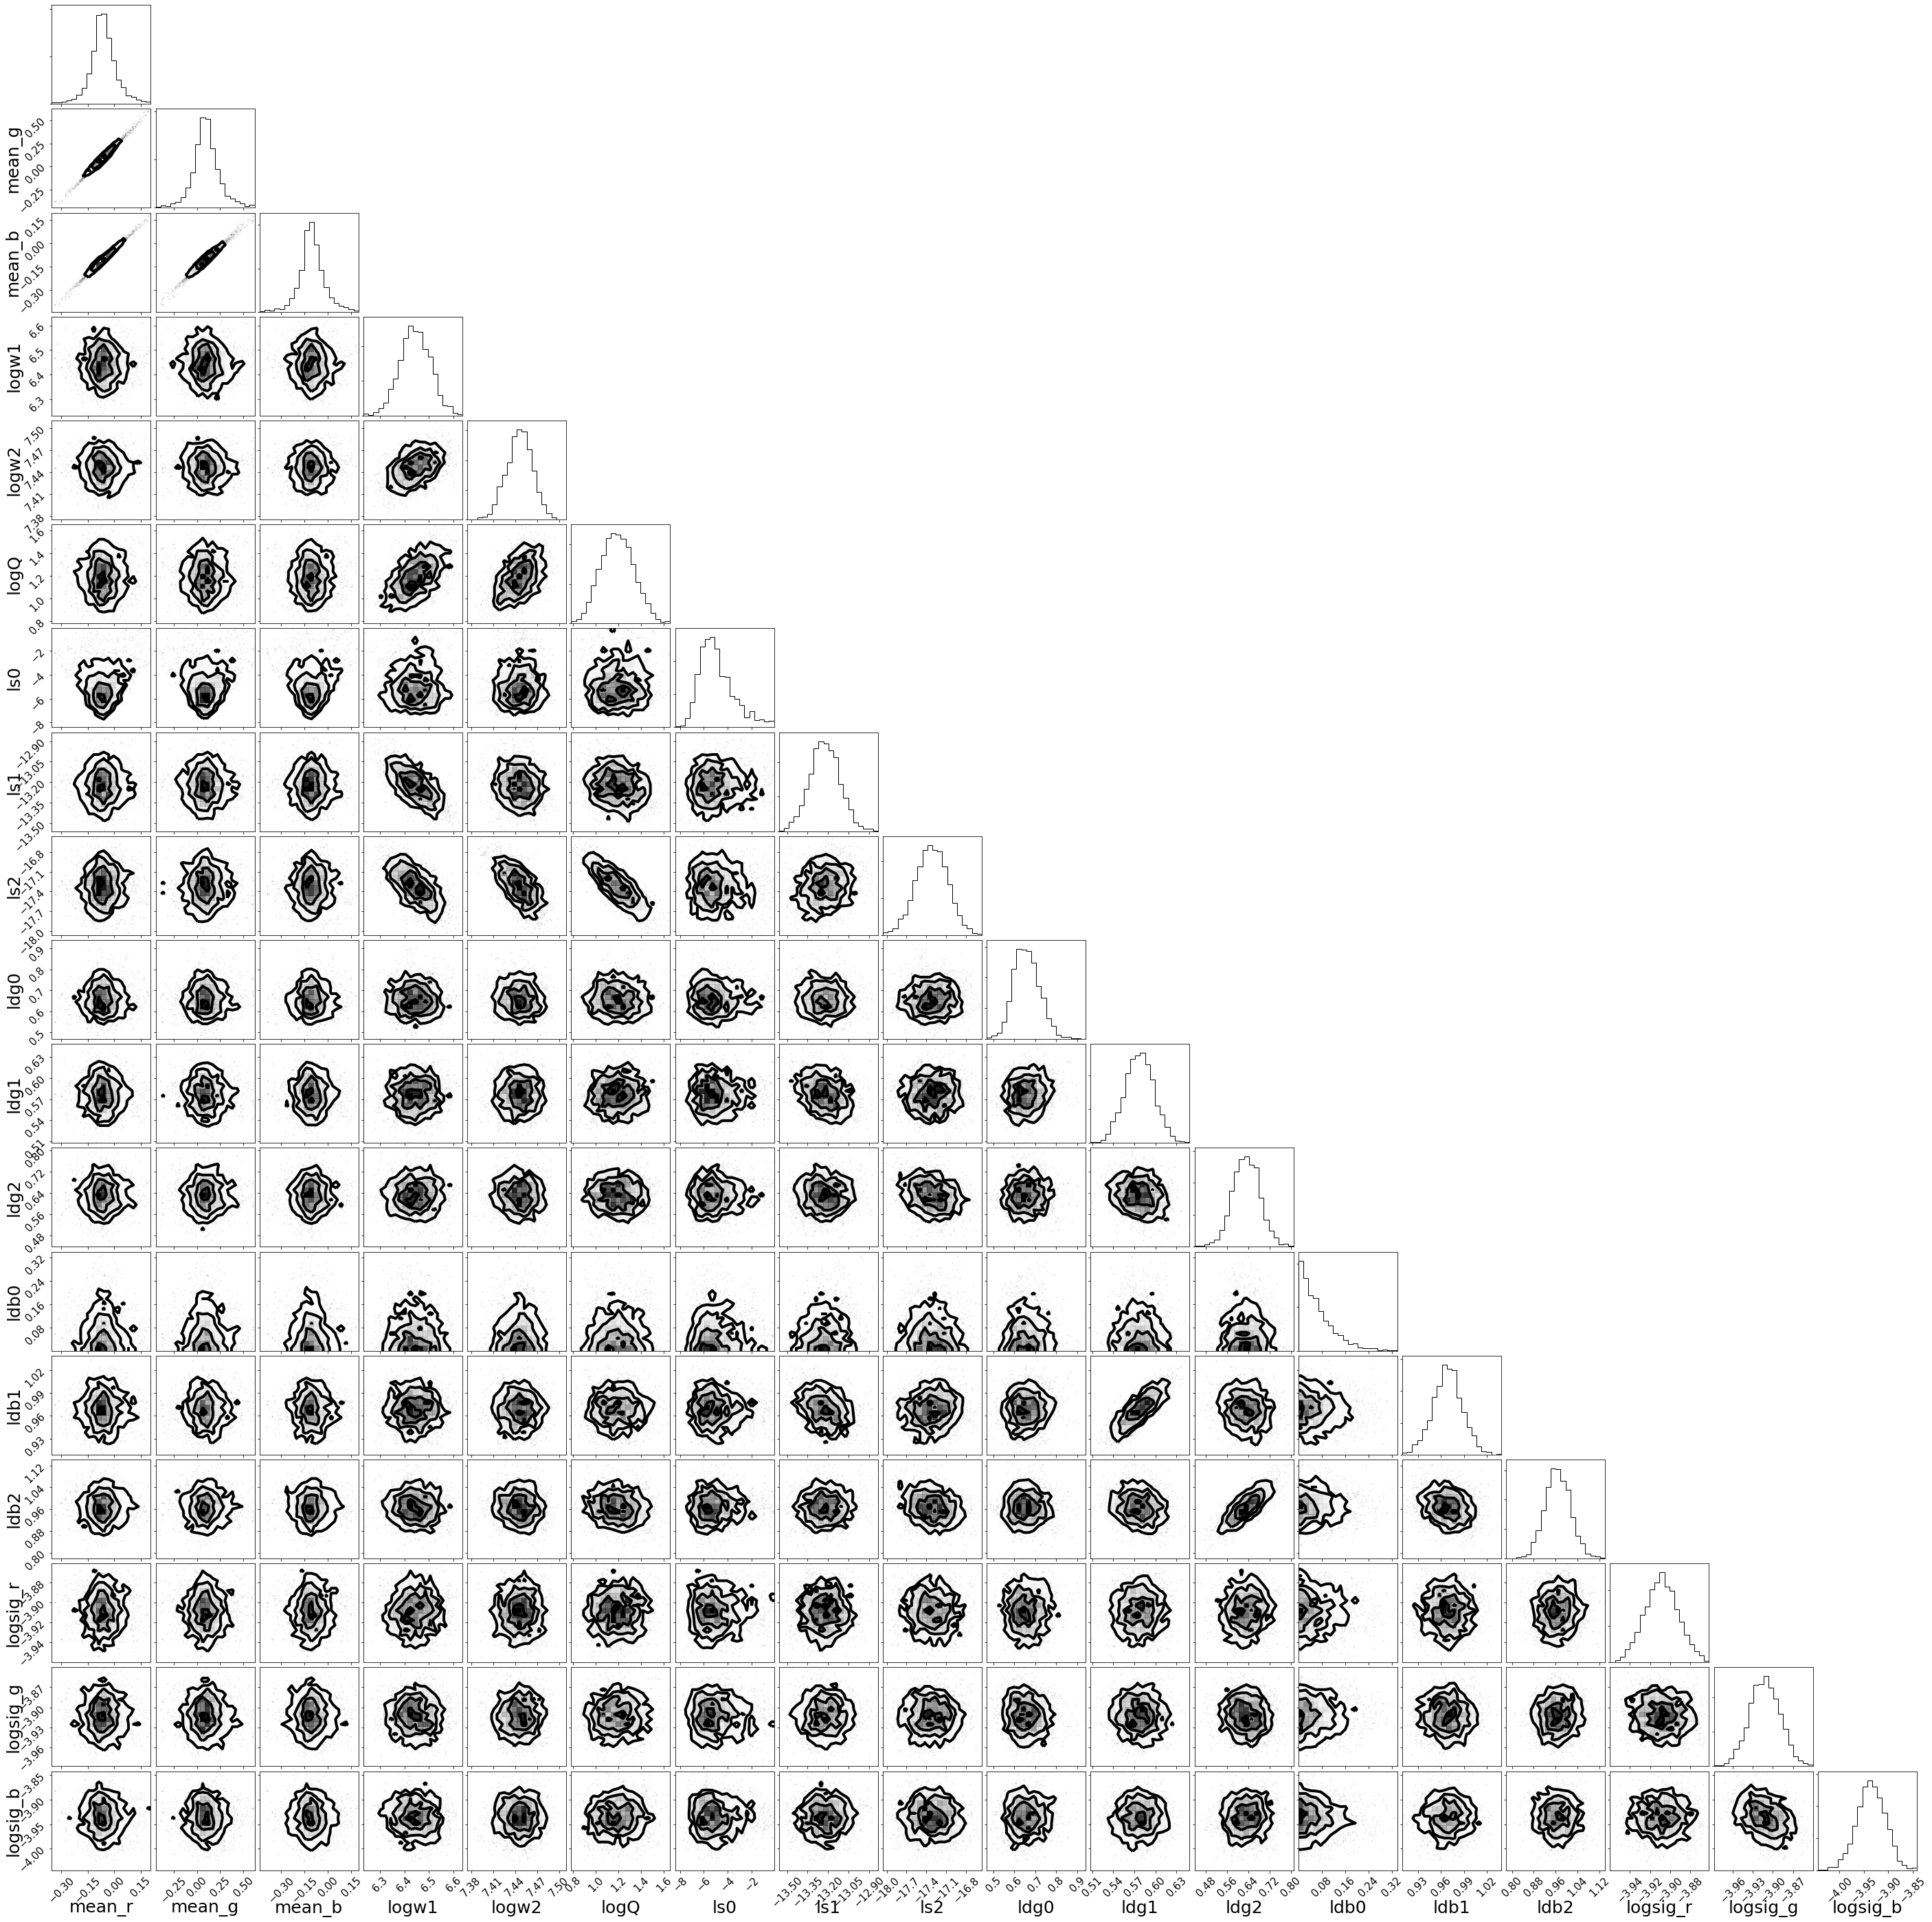

In [16]:
samples = pm.trace_to_dataframe(trace, varnames=['mean_r', 'mean_g', 'mean_b', 
                                                'logw1', 'logw2', 
                                                'logQ',
                                                'ls0', 'ls1', 'ls2',
                                                'ldg0', 'ldg1', 'ldg2', 
                                                'ldb0', 'ldb1', 'ldb2', 
                                                'logsig_r', 'logsig_g', 'logsig_b'])
_ = corner.corner(samples)

In [17]:
s = [np.random.randint(len(trace)) for n in range(10)]
kernels = [get_kernel(trace[s]) for s in s]
psds = [k.psd(2*np.pi*f).T.eval() for k in kernels]

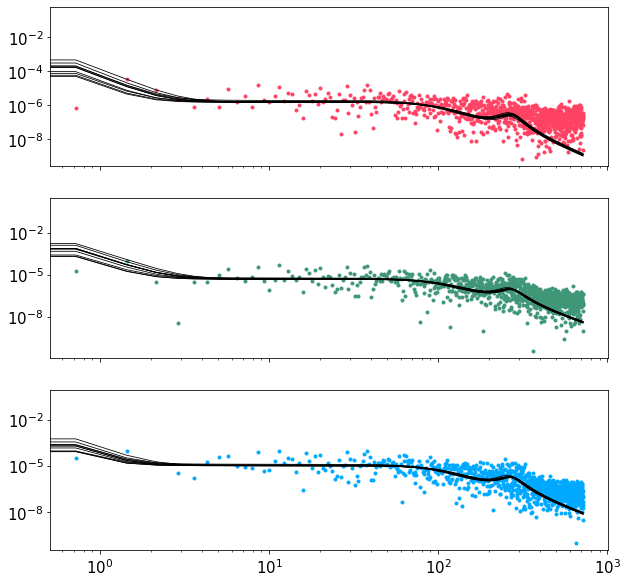

In [18]:
fig, ax = pl.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].loglog(f, powerfftr, '.', color=mpld.red)
ax[1].loglog(f, powerfftg, '.', color=mpld.green)
ax[2].loglog(f, powerfftb, '.', color=mpld.blue)

for psd in psds:
    ax[0].loglog(f, psd[0], color='k', linewidth=0.8)
    ax[1].loglog(f, psd[1], color='k', linewidth=0.8)
    ax[2].loglog(f, psd[2], color='k', linewidth=0.8)

In [41]:
m = 3
gp = xo.gp.GP(kernels[2], t, np.exp(-10)*np.ones((m, len(t))) ** 2, J=6)
z = gp.dot_l(np.random.randn(m*len(t), 1)).eval()

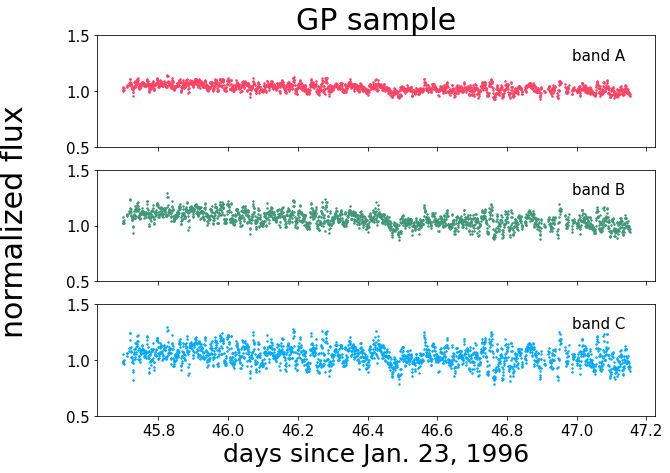

In [49]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+z[::3], '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+z[1::3], '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+z[2::3], '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('band A', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('band B', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('band C', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

ax[0].set_title("GP sample")

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/sample.pdf")

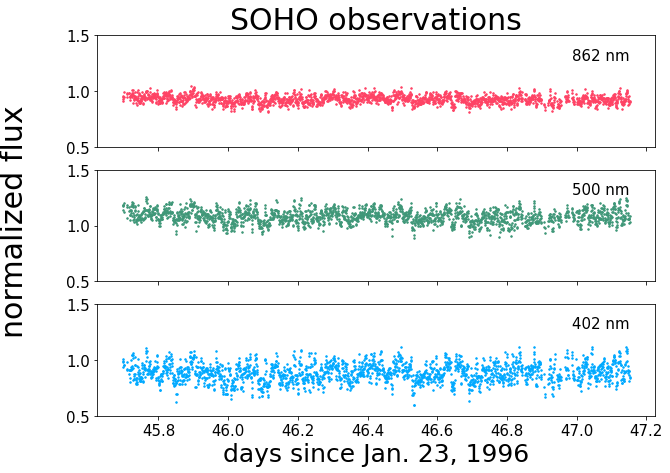

In [51]:
fig, ax = pl.subplots(3, 1, figsize=(10, 7), sharex=True)
ax[0].plot(t, 1+r, '.', color=mpld.red, alpha=1, ms=3.0)
ax[1].plot(t, 1+g, '.', color=mpld.green, alpha=1, ms=3.0)
ax[2].plot(t, 1+b, '.', color=mpld.blue, alpha=1, ms=3.0)

ax[0].annotate('862 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[1].annotate('500 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)
ax[2].annotate('402 nm', xy=(0.85, 0.78), xycoords='axes fraction', fontsize=15)

ax[0].set_title("SOHO observations")

[ax.set_ylim(0.5, 1.5) for ax in ax]
ax[2].set_xlabel('days since Jan. 23, 1996')
pl.annotate("normalized flux", xy=(0.0, 0.3), 
            xycoords='figure fraction', 
            rotation=90, fontsize=30)
pl.savefig("/Users/tgordon/Desktop/spm_lc.pdf")

In [54]:
pm.summary(trace).keys()

Index(['mean', 'sd', 'hpd_3%', 'hpd_97%', 'mcse_mean', 'mcse_sd', 'ess_mean',
       'ess_sd', 'ess_bulk', 'ess_tail', 'r_hat'],
      dtype='object')

In [61]:
print(pm.stats.ess(trace))

<xarray.Dataset>
Dimensions:   ()
Data variables:
    mean_r    float64 466.1
    mean_g    float64 469.2
    mean_b    float64 458.7
    logw0     float64 412.3
    logw1     float64 1.755e+03
    logw2     float64 2.164e+03
    logQ      float64 1.957e+03
    ls0       float64 514.6
    ls1       float64 2.22e+03
    ls2       float64 1.615e+03
    ldg0      float64 857.1
    ldg1      float64 2.308e+03
    ldg2      float64 2.229e+03
    ldb0      float64 677.2
    ldb1      float64 2.568e+03
    ldb2      float64 2.281e+03
    logsig_r  float64 2.113e+03
    logsig_g  float64 2.276e+03
    logsig_b  float64 2.446e+03
